# ICL evluation beased on LongBench

In [14]:
import pandas as pd
import time
from tqdm import tqdm
import os
import re
import string
from collections import Counter
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from rouge_score import rouge_scorer
from bert_score import score
from nltk.translate import meteor_score
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
import matplotlib.pyplot as plt
from openai import OpenAI
from bert_score import BERTScorer


file_name = "exp_result_Mixtral-8x7B-Instruct-v0.1_20240507200347.csv"
foler_path = "Paper Experiment Results/New_filtered/Summary"

output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
bleurt_model_name = "Elron/bleurt-large-512"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

In [15]:
def calculate_rouge_scores(row):
    answer = row["pure_response"]
    reference = row["humman_summary"]
    scorer = rouge_scorer.RougeScorer(["rougeL"])
    scores = scorer.score(answer, reference)
    precision = scores["rougeL"][0]
    recall = scores["rougeL"][1]
    fmeasure = scores["rougeL"][2]
    return pd.Series({"precision": precision, "recall": recall, "fmeasure": fmeasure})


def bart_score(candidate, reference):
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
    inputs = tokenizer(candidate, return_tensors="pt", max_length=1024, truncation=True)
    labels = tokenizer(reference, return_tensors="pt", max_length=1024, truncation=True)
    score = model(**inputs, labels=labels)["loss"].item()
    return score


def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


def bert_score(row, scorer):
    candidate = row["pure_response"]
    reference = row["humman_summary"]
    P, R, F1 = scorer.score([candidate], [reference])
    return P[0].item(), R[0].item(), F1[0].item()


def meteor_score_evaluate(row):
    candidate = row["pure_response"]
    reference = row["humman_summary"]
    score = meteor_score.meteor_score([reference], candidate)
    return score

In [16]:
from tqdm import tqdm

tqdm.pandas()
scorer = BERTScorer(model_type="bert-large-uncased")
_data["pure_response"] = _data.progress_apply(extract_pure_response, axis=1)
new_columns = _data.progress_apply(calculate_rouge_scores, axis=1)
_data["rouge_l_precision"] = new_columns["precision"]
_data["rouge_l_recall"] = new_columns["recall"]
_data["rouge_l_fmeasure"] = new_columns["fmeasure"]
_data[["bert_P", "bert_R", "bert_F1"]] = _data.progress_apply(
    lambda row: bert_score(row, scorer), axis=1, result_type="expand"
)

100%|██████████| 2114/2114 [05:02<00:00,  6.99it/s]


In [17]:
_data.to_csv(output_path, index=False)

# Draw together

In [29]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
output_photo_name = f"SUM_{current_time_str}.svg"
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}

marker_map = {
    "Llama-2-7b-chat-hf": ".",
    "Llama-2-13b-chat-hf": "*",
    "Llama-2-70b-chat-hf": "o",
    "Meta-Llama-3-8B-Instruct": "+",
    "Meta-Llama-3-70B-Instruct": "^",
    "Mistral-7B-Instruct-v0.2": "<",
    "Mixtral-8x7B-Instruct-v0.1": ">",
}

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]
color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
}

folder_path = "Paper Experiment Results/New_filtered/Summary"
output_photo_name = f"SUM_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["model_encoded"] = df["model_name"].map(model_map)

In [30]:
df[df["pure_response"].isna()].count()

Unnamed: 0                         17
Temperature                        17
article                            17
humman_summary                     17
initial_prompt                     17
llama2_chat_initial_prompt         17
llama3_chat_initial_prompt         17
mixtral_instruct_initial_prompt    17
SYSTEM_MESSAGE                     17
USER_MESSAGE                       17
generated_response                 17
timestamp                          17
elapsed_time                       17
temperature                        17
model                              17
pure_response                       0
rouge_l_precision                  17
rouge_l_recall                     17
rouge_l_fmeasure                   17
bert_P                             17
bert_R                             17
bert_F1                            17
model_name                         17
weight_size                        17
model_encoded                      17
dtype: int64

In [31]:
df[df["rouge_l_fmeasure"] <= 0.0].count()

Unnamed: 0                         30
Temperature                        30
article                            30
humman_summary                     30
initial_prompt                     30
llama2_chat_initial_prompt         30
llama3_chat_initial_prompt         30
mixtral_instruct_initial_prompt    30
SYSTEM_MESSAGE                     30
USER_MESSAGE                       30
generated_response                 30
timestamp                          30
elapsed_time                       30
temperature                        30
model                              30
pure_response                      13
rouge_l_precision                  30
rouge_l_recall                     30
rouge_l_fmeasure                   30
bert_P                             30
bert_R                             30
bert_F1                            30
model_name                         30
weight_size                        30
model_encoded                      30
dtype: int64

In [32]:
df = df[df["rouge_l_fmeasure"] > 0]

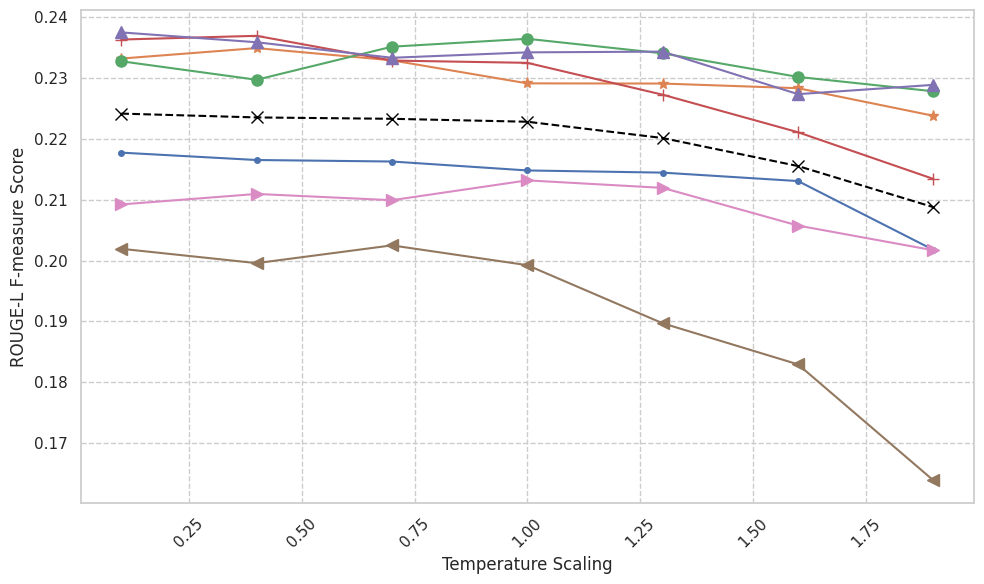

In [33]:
grouped_data = df.groupby(["model", "Temperature"])["rouge_l_fmeasure"].mean()

plt.figure(figsize=(10, 6))
for i, (model, color) in enumerate(color_map.items()):
    model_data = grouped_data[model]
    marker = marker_map[model]
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        color=color,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["rouge_l_fmeasure"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("ROUGE-L F-measure Score")
# plt.title("Summarization\n Mean ROUGE-L F-measure with Temperature Across Models")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [34]:
df[(df["model"] == "Mixtral-8x7B-Instruct-v0.1") & (df["rouge_l_fmeasure"] < 0.3)]

,Unnamed: 0,Temperature,article,humman_summary,initial_prompt,llama2_chat_initial_prompt,llama3_chat_initial_prompt,mixtral_instruct_initial_prompt,SYSTEM_MESSAGE,USER_MESSAGE,...,pure_response,rouge_l_precision,rouge_l_recall,rouge_l_fmeasure,bert_P,bert_R,bert_F1,model_name,weight_size,model_encoded
1,1.0,0.1,Nick Scholfield is lined up to ride Spring Hee...,Preparation is taking place for a horse ridin...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,...,Nick Scholfield has been selected to ride Jim ...,0.242424,0.123077,0.163265,0.541148,0.586628,0.562971,Llama-2-7b-chat-hf,7,0
3,3.0,0.1,Dr Mehmet Oz's fellow faculty members at Colum...,Faculty at Columbia University have written an...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,...,"Dr. Mehmet Oz, a professor at Columbia Univers...",0.313725,0.132231,0.186047,0.566356,0.680281,0.618113,Llama-2-7b-chat-hf,7,0
4,4.0,0.1,Dr Mehmet Oz's fellow faculty members at Colum...,"Celebrity doctor, Mehmet Oz, is being attacked...",\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,...,"Dr. Mehmet Oz, a professor at Columbia Univers...",0.283019,0.100671,0.148515,0.566333,0.678967,0.617556,Llama-2-7b-chat-hf,7,0
5,5.0,0.1,"""It's all about taking an opportunity in a cri...",Four years after finally building a modern Cou...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,...,Incoming Conservative leader of Melton Borough...,0.369565,0.122302,0.183784,0.528610,0.615410,0.568717,Llama-2-7b-chat-hf,7,0
6,6.0,0.1,"""It's all about taking an opportunity in a cri...",Leicestershire is the lowest-funded county in ...,\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,...,Incoming Conservative leader Byron Rhodes of M...,0.423077,0.079137,0.133333,0.483207,0.678353,0.564387,Llama-2-7b-chat-hf,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,NaN,1.9,An Oxford college has moved away from its foun...,"Ruskin College, a sub-college of Oxford, is cu...",\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is good at summarizing ar...,Summarize the following article in 1 to 3 sent...,...,"Ruskin College, a historically left-wing insti...",0.384615,0.083799,0.137615,0.458874,0.678461,0.547469,Llama-2-70b-chat-hf,70,2
14790,NaN,1.9,An Oxford college has moved away from its foun...,"To streamline costs, an Oxford college has dis...",\nRole: You are a writer who is good at summar...,\n<s>[INST] <<SYS>>\nYou are a writer who is g...,\n<|begin_of_text|><|start_header_id|>system<|...,<s>[INST]\nYou are a writer who is good at sum...,You are a writer who is go

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


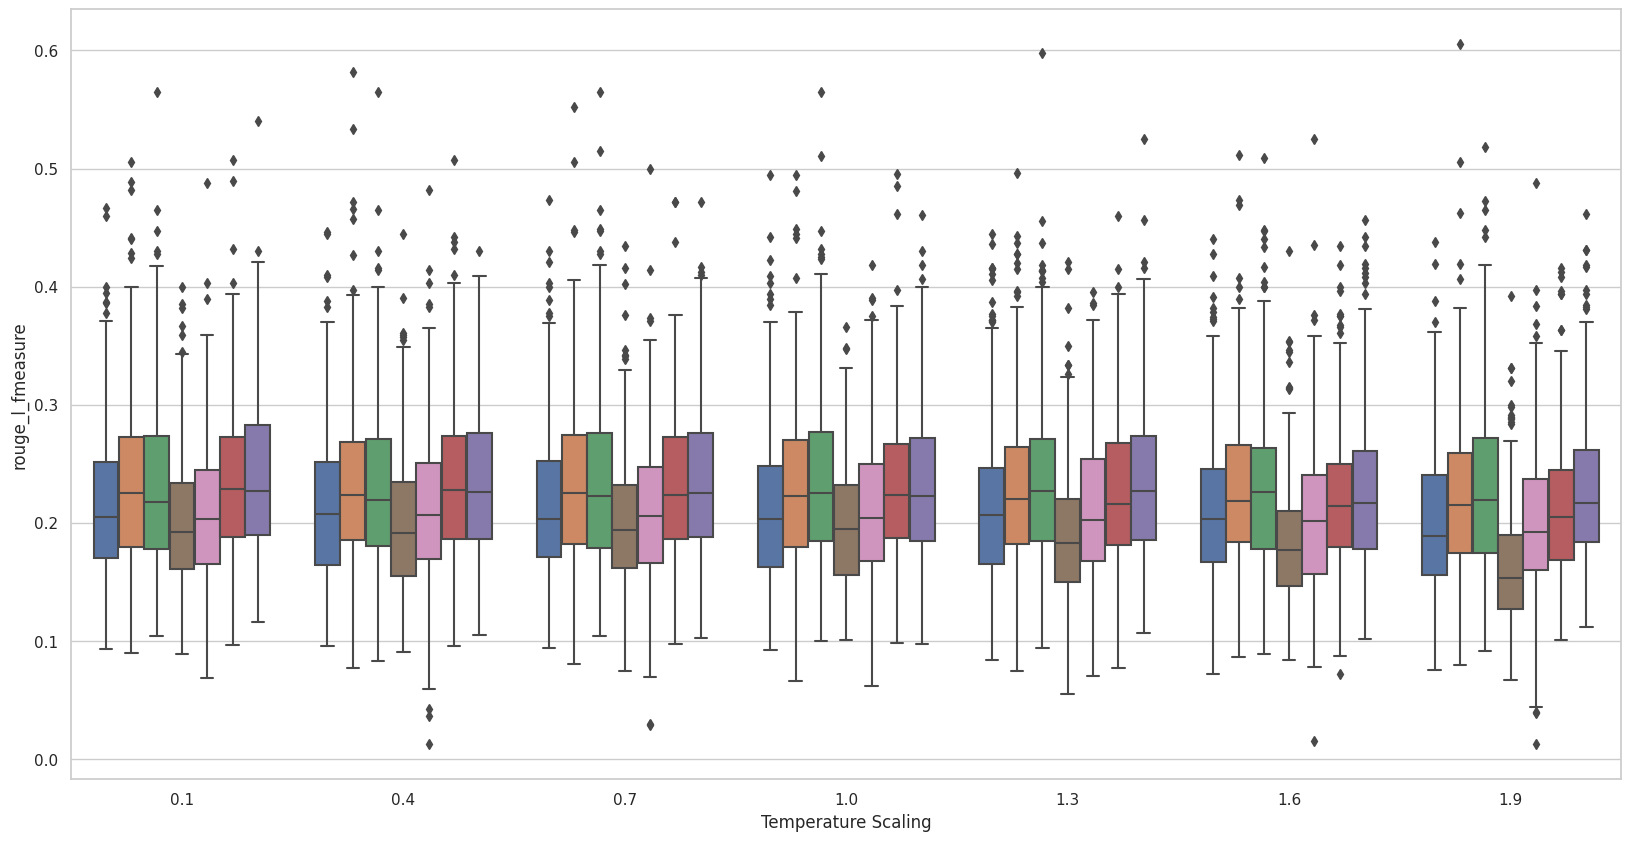

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
}
model_order = list(color_map.keys())
df["Temperature"] = df["Temperature"].round(1)

# Create a single plot
fig, ax = plt.subplots(figsize=(20, 10))

# Boxplot
sns.boxplot(
    x="Temperature",
    y="rouge_l_fmeasure",
    hue="model",
    data=df,
    palette=color_map,
    hue_order=model_order,
    ax=ax,
)

# ax.set_title("Boxplot Temperature vs spbleu")
ax.set_xlabel("Temperature Scaling")
ax.set_ylabel("rouge_l_fmeasure")
# ax.legend(loc="upper left")
ax.legend_.remove()
# Adjust layout
# plt.tight_layout()
plt.savefig("Summary_BOX_PLOT.svg", format="svg", bbox_inches="tight")
# Show the plot
plt.show()

In [3]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    accuracy = model_data["rouge_l_fmeasure"].values

    corr, p_value = spearmanr(temperatures, accuracy)

    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()

    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj

    beta_hat = model.params

    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


results_df = pd.DataFrame(results)


# # Print or use the results as needed
# for model in models:
#     # print(f"Model: {model}")
#     print(f"{correlations[model]}")
# print()
# for model in models:
#     print(f"{p_values[model]}")

# for model in models:
#     print(f"Model: {model}")
#     print(f"Kendall correlation: {correlations[model]}")
#     print(f"p-value: {p_values[model]}")
#     print(f"OLS summary:")
#     print(ols_results[model].summary())
#     print()

# results_df.to_csv("output.csv")

# Causal Estimation

In [6]:
import pandas as pd
import os
import datetime
import numpy as np
import warnings
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression

# Data Preprocessing
warnings.filterwarnings("ignore")
current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")

folder_path = "Paper Experiment Results/New_filtered/Summary"
output_photo_name = f"SUM_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]
df["initial_prompt_length"] = df["initial_prompt"].apply(len)
df["Temperature"] = df["Temperature"].round(1)
node_labels = [
    "Temperature",
    "model_encoded",
    "initial_prompt_length",
    "bert_F1",
    "rouge_l_fmeasure",
    "time_per_char",
]

causal_dataset_df = df[node_labels]

grouped = causal_dataset_df.groupby(["model_encoded", "Temperature"])

train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]
    validation = group.iloc[split_index:]
    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

# Temperature Scaling
start = 0.1
stop = 2.1
step = 0.3
control_values = np.arange(start, stop, step)

In [7]:
max_rouge_l_fmeasure = causal_dataset_df.groupby("model_encoded")[
    "rouge_l_fmeasure"
].max()

max_rouge_df = max_rouge_l_fmeasure.reset_index()

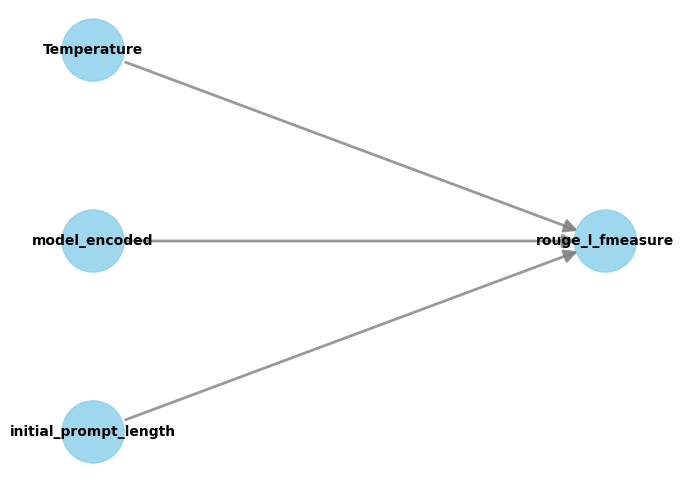

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                            
──────────────(E[rouge_l_fmeasure])
d[Temperature]                     
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→rouge_l_fmeasure then P(rouge_l_fmeasure|Temperature,,U) = P(rouge_l_fmeasure|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [8]:
model = CausalModel(
    data=causal_dataset_df,
    treatment=["Temperature"],
    outcome=["rouge_l_fmeasure"],
    effect_modifiers=["model_encoded", "initial_prompt_length"],
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

model_y = LinearRegression(fit_intercept=True)
model_t = LinearRegression(fit_intercept=True)

result_df = pd.DataFrame()
model_list = causal_dataset_df["model_encoded"].unique().tolist()
for control_value in control_values:
    dml_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.econml.dml.LinearDML",
        confidence_intervals=True,
        control_value=control_value,
        treatment_value=control_value + step,
        method_params={
            "init_params": {
                "model_y": model_y,
                "model_t": model_t,
            }
        },
        fit_estimator=True,
    )
    for model_encoded in model_list:
        max_value = max_rouge_df[max_rouge_df["model_encoded"] == model_encoded][
            "rouge_l_fmeasure"
        ].values[0]
        dml_estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.econml.dml.LinearDML",
            target_units=validation_set[
                validation_set["model_encoded"] == model_encoded
            ],
            confidence_intervals=True,
            control_value=control_value,
            treatment_value=control_value + step,
            method_params={
                "init_params": {
                    "model_y": model_y,
                    "model_t": model_t,
                }
            },
            fit_estimator=False,
        )
        estimate_value = dml_estimate.cate_estimates[0]
        lower_bound = dml_estimate.get_confidence_intervals()[:, :, 0][0][0]
        upper_bound = dml_estimate.get_confidence_intervals()[:, :, 0][1][0]
        data = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "estimate_value": estimate_value,
            "estimate_max0": (estimate_value / max_value) * 100,
            "control_value": control_value,
            "model_encoded": model_encoded,
        }
        data_df = pd.DataFrame(data)
        result_df = pd.concat([result_df, data_df], ignore_index=True)

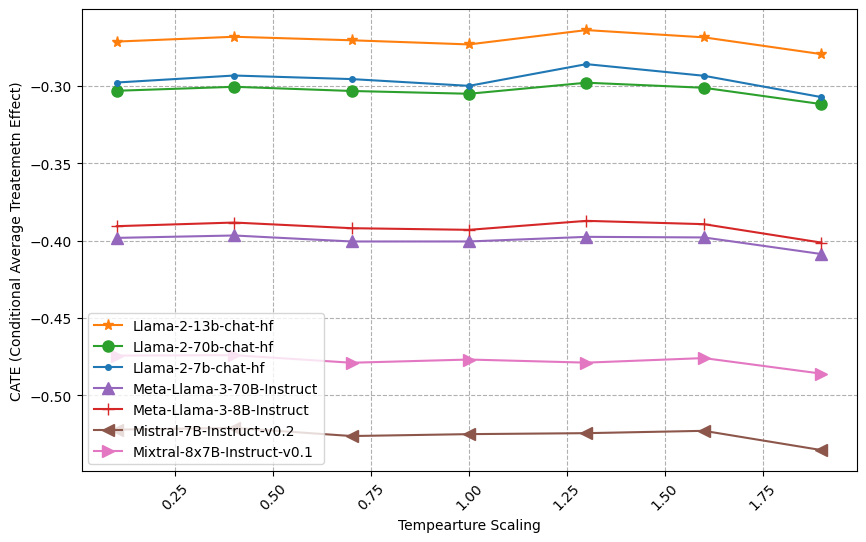

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

reversed_model_map = {value: key for key, value in model_map.items()}
result_df["control_value"] = result_df["control_value"].round(1)
result_df["model_name"] = result_df["model_encoded"].map(reversed_model_map)
grouped = result_df.groupby("model_name")

plt.figure(figsize=(10, 6))
i = 0
for name, group in grouped:
    plt.plot(
        group["control_value"],
        group["estimate_max0"],
        label=name,
        color=color_map[name],
        marker=marker_map[name],
        markersize=8,
    )
    # plt.fill_between(group['control_value'], group['lower_bound'], group['upper_bound'], alpha=0.01)
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.legend()

plt.xlabel("Tempearture Scaling")
plt.ylabel("CATE (Conditional Average Treatemetn Effect)")
# plt.title("Estimate Value vs Control Value for Different Model Encodings")
plt.show()

# PCA

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.colors as mcolors
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from transformers import GPT2Tokenizer, GPT2Model
import torch
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [6]:
current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/Summary"
output_photo_name = f"SUM_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")


def get_paragraph_embedding(paragraph):
    inputs = tokenizer(paragraph, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().numpy()


# Assuming df is your DataFrame
temperatures = df["Temperature"].tolist()
grouped_responses = {}
for index, row in df.iterrows():
    temp = row["Temperature"]
    if row["Temperature"] not in grouped_responses:
        grouped_responses[temp] = []
    grouped_responses[temp].append(index)

plt.figure(figsize=(10, 8))

colors = plt.cm.get_cmap("tab20", len(grouped_responses))

all_embeddings = []
all_labels = []

for i, (temp, indices) in enumerate(grouped_responses.items()):
    group_responses = df.loc[indices, "pure_response"].tolist()[:100]
    embeddings = np.vstack(
        [get_paragraph_embedding(response) for response in group_responses]
    )
    all_embeddings.append(embeddings)
    all_labels.extend([temp] * len(embeddings))

/tmp/ipykernel_2039477/4233442666.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(grouped_responses))


<Figure size 1000x800 with 0 Axes>

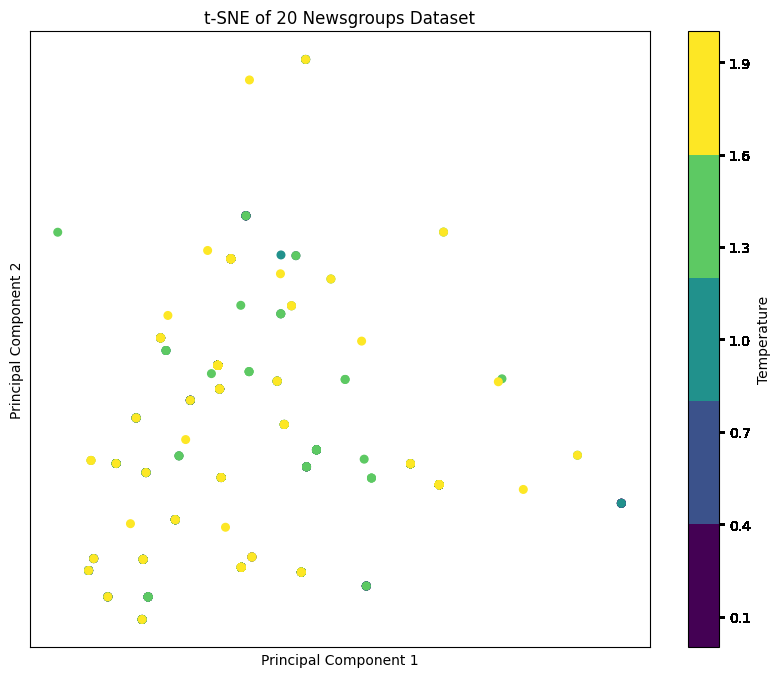

In [10]:
X_vec = np.vstack(all_embeddings)
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X_vec)
plt.figure(figsize=(10, 8))
cmap = mcolors.ListedColormap(["#440154", "#3b528b", "#21918c", "#5dc963", "#fde725"])
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_labels, cmap=cmap, s=30)
plt.colorbar(scatter, ticks=all_labels, label="Temperature")
plt.clim(0.0, max(all_labels) + 0.1)
plt.xticks([])
plt.yticks([])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("t-SNE of 20 Newsgroups Dataset")
plt.show()

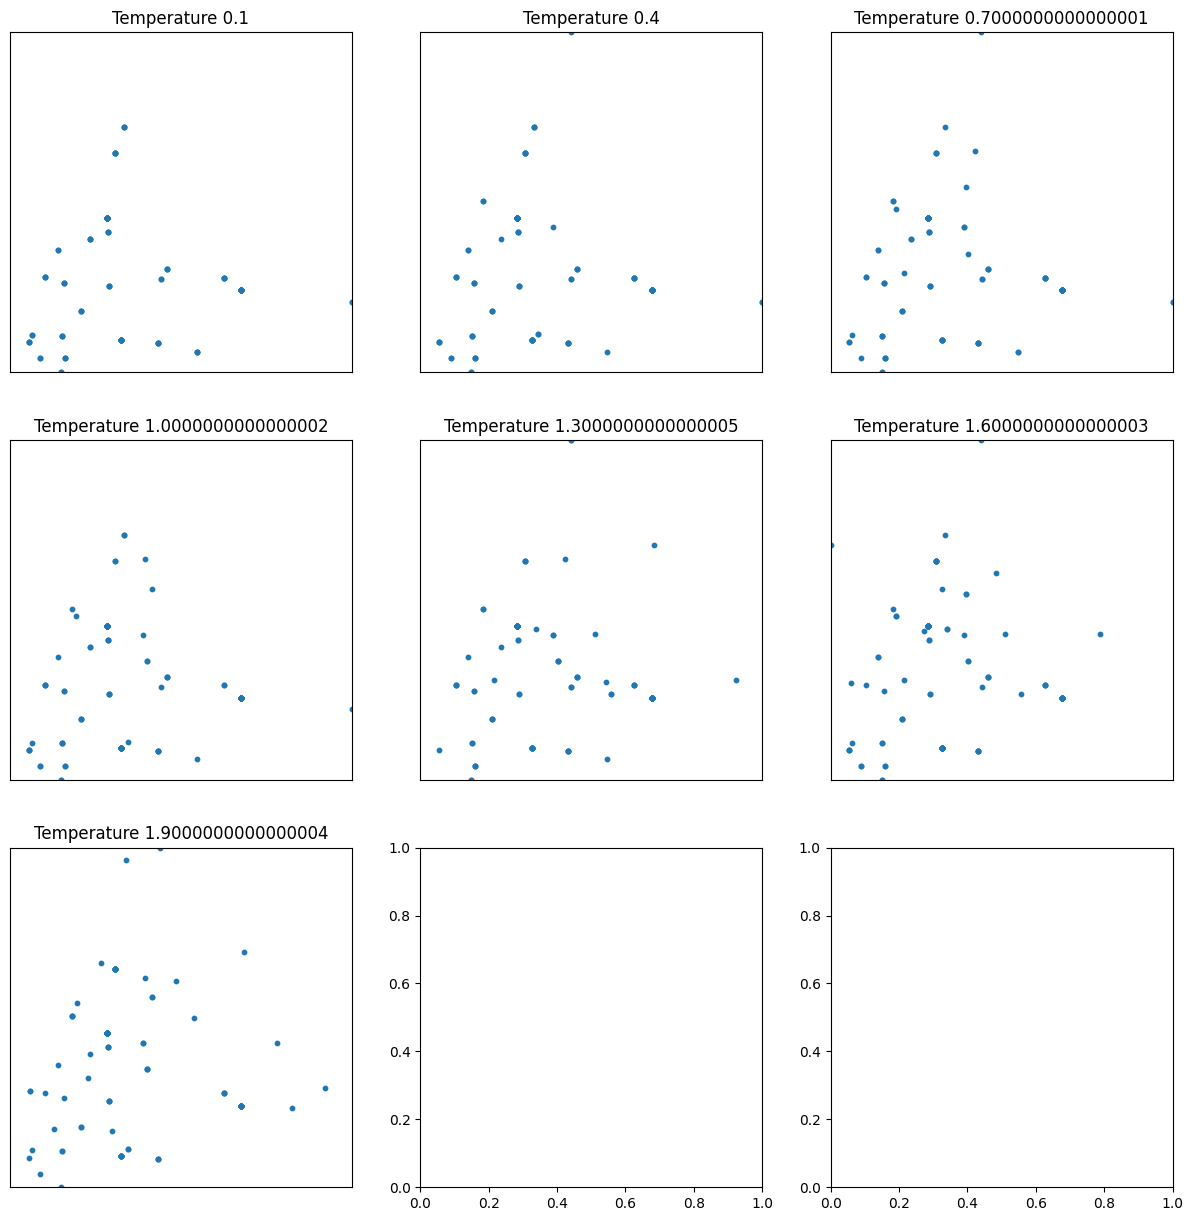

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
all_labels = np.array(all_labels)
unique_labels = list(sorted(set(all_labels)))
max_x = np.max(X_embedded[:, 0])
max_y = np.max(X_embedded[:, 1])
min_x = np.min(X_embedded[:, 0])
min_y = np.min(X_embedded[:, 1])

for label, ax in zip(range(7), axes.flat):
    temperature = unique_labels[label]
    label_indices = np.where(all_labels == temperature)[0]
    ax.scatter(
        X_embedded[label_indices, 0],
        X_embedded[label_indices, 1],
        s=10,
        label=f"Temperature {temperature}",
    )
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Temperature {temperature}")

# Causal Discovery

In [13]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)


def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine="dot")
    names = labels if labels else [f"x{i}" for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d


def str_to_dot(string):
    graph = string.strip().replace("\n", ";").replace("\t", "")
    graph = graph[:9] + graph[10:-2] + graph[-1]
    return graph

(14798, 24)

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/5 [00:00<?, ?it/s]

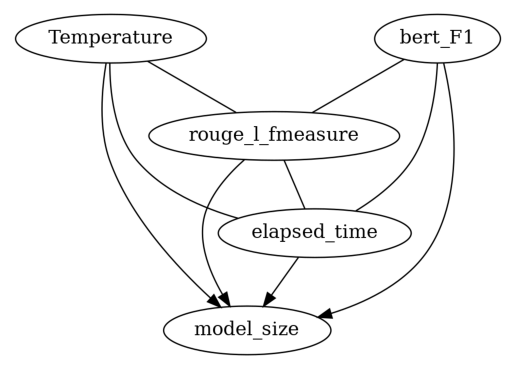

In [16]:
from causallearn.search.ConstraintBased.PC import pc

model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}
df["model_size"] = model_weight_sizes.get(model_name, None)
node_labels = [
    "Temperature",
    "model_size",
    "bert_F1",
    "rouge_l_fmeasure",
    "elapsed_time",
]

causal_dataset = df[node_labels].values
cg = pc(causal_dataset)
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=node_labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format="png")
plt.axis("off")
plt.imshow(img)
plt.show()

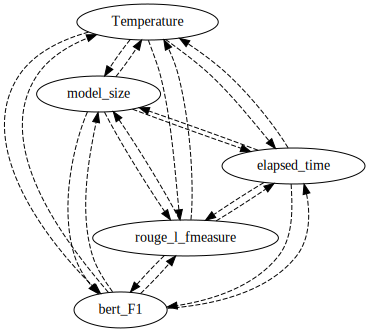

In [51]:
import numpy as np
import pandas as pd

import graphviz
import lingam
from lingam.utils import make_prior_knowledge, make_dot

i = 0
num_labels = []
for label in node_labels:
    num_labels.append(str(i) + " : " + label)
    i = i + 1


def make_prior_knowledge_graph(prior_knowledge_matrix, labels):
    d = graphviz.Digraph(engine="dot")

    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style="dashed")
    return d


prior_knowledge = make_prior_knowledge(n_variables=5)
make_prior_knowledge_graph(prior_knowledge, labels=node_labels)

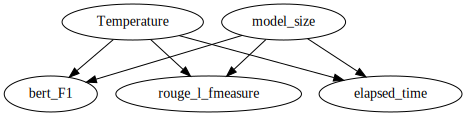

In [103]:
# PC

from castle.common.priori_knowledge import PrioriKnowledge
from castle.algorithms import PC
from castle.common.independence_tests import CITest

priori_knowledge = PrioriKnowledge(n_nodes=5)
priori_knowledge.add_required_edges([(3, 0), (2, 0), (4, 0), (3, 1), (2, 1), (4, 1)])
priori_knowledge.add_forbidden_edges(
    [
        (0, 1),
        (1, 0),
        (2, 3),
        (3, 2),
        (2, 4),
        (4, 2),
        (4, 3),
        (3, 4),
        (0, 2),
        (0, 3),
        (0, 4),
        (1, 2),
        (1, 3),
        (1, 4),
    ]
)
pc_priori = PC(priori_knowledge=priori_knowledge, variant="stable")
pc_priori.learn(causal_dataset)
make_prior_knowledge_graph(priori_knowledge.matrix, labels=node_labels)
make_prior_knowledge_graph(pc_priori.causal_matrix, labels=node_labels)

# Causal Modleling And Estimation

## GCM bases

In [22]:
import pandas as pd
import time
from tqdm import tqdm
import os
import re
import string
from collections import Counter
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from rouge_score import rouge_scorer
from bert_score import score
from nltk.translate import meteor_score
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
import matplotlib.pyplot as plt
from openai import OpenAI
from bert_score import BERTScorer
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx
import os

from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased.lingam.utils import make_dot
from dowhy import CausalModel
import dowhy.gcm as gcm


current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/Summary"
output_photo_name = f"SUM_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["model_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]


node_labels = [
    "Temperature",
    "model",
    "model_size",
    "bert_F1",
    "rouge_l_fmeasure",
    "time_per_char",
]
causal_dataset_df = df[node_labels]

In [2]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx
import os

from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased.lingam.utils import make_dot
from dowhy import CausalModel
import dowhy.gcm as gcm


node_labels = [
    "Temperature",
    "model_size",
    "bert_F1",
    "rouge_l_fmeasure",
    "time_per_char",
]
causal_dataset_df = df[node_labels]

/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:
grouped = causal_dataset_df.groupby(["Temperature", "model_size"])

train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    train = group.sample(frac=0.6, random_state=42)
    validation = group.drop(train.index)

    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(validation_set)}")

causal_graph = nx.DiGraph(
    [
        ("Temperature", "bert_F1"),
        ("Temperature", "rouge_l_fmeasure"),
        ("Temperature", "time_per_char"),
        ("model_size", "bert_F1"),
        ("model_size", "rouge_l_fmeasure"),
        ("model_size", "time_per_char"),
    ]
)
pos = nx.spring_layout(causal_graph)
nx.draw(
    causal_graph,
    pos,
    with_labels=True,
    node_color="skyblue",
    node_size=1000,
    font_size=10,
    arrowsize=20,
)
plt.show()

Train set size: 7602
Validation set size: 5082


In [5]:
causal_model = gcm.StructuralCausalModel(
    causal_graph
)  # Automatic set the causal effect

# quality = gcm.auto.AssignmentQuality.BEST
summary_auto_assignment = gcm.auto.assign_causal_mechanisms(causal_model, train_set)
print(summary_auto_assignment)

gcm.fit(causal_model, train_set)

/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.ba

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node model_size: 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]      


In [6]:
causal_model.causal_mechanism("Temperature")
for node in causal_model.graph.nodes:
    print(f"Node: {node}   {causal_model.causal_mechanism(node)}")

Node: Temperature   Empirical Distribution
Node: bert_F1   AdditiveNoiseModel using Pipeline
Node: rouge_l_fmeasure   AdditiveNoiseModel using HistGradientBoostingRegressor
Node: time_per_char   AdditiveNoiseModel using HistGradientBoostingRegressor
Node: model_size   Empirical Distribution


Evaluating causal mechanisms...: 100%|██████████| 5/5 [00:00<00:00, 2525.47it/s]
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend

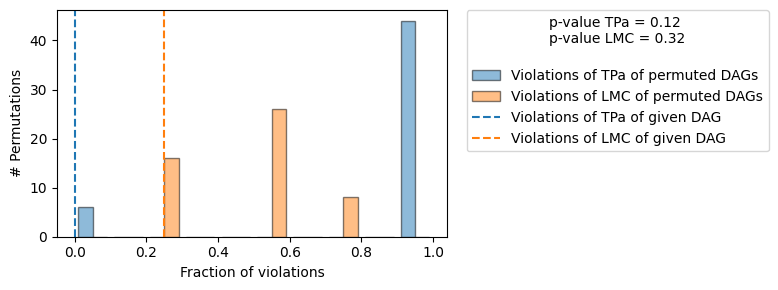

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [7]:
summary_evaluation = gcm.evaluate_causal_model(
    causal_model, validation_set, compare_mechanism_baselines=True
)
print(summary_evaluation)

# Causal Model Bases On Dowhy With DML

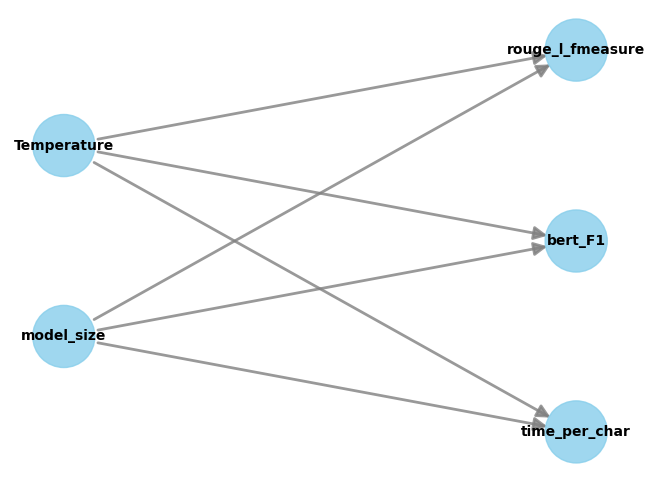

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                            
──────────────(E[rouge_l_fmeasure])
d[Temperature]                     
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→rouge_l_fmeasure then P(rouge_l_fmeasure|Temperature,,U) = P(rouge_l_fmeasure|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [10]:
from dowhy import CausalModel

model = CausalModel(
    data=train_set,
    treatment=["Temperature"],
    outcome=["rouge_l_fmeasure", "bert_F1", "time_per_char"],
    effect_modifiers=["model_size"],
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

Test permutations of given graph:  22%|██▏       | 26/120 [00:48<02:39,  1.69s/it]/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
Test permutations of given graph:  23%|██▎       | 28/120 [00:58<03:20,  2.17s/it]/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/pytho

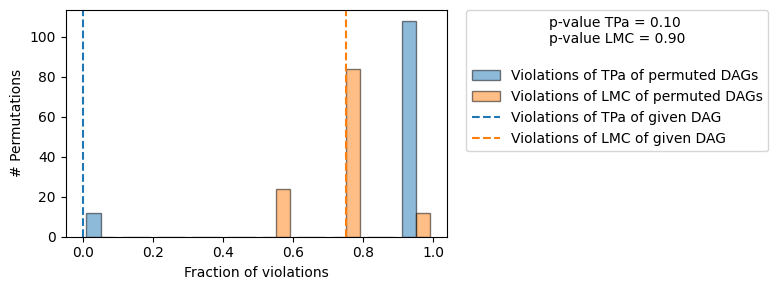

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is not informative because 12 / 120 of the permutations lie in the Markov               |
| equivalence class of the given DAG (p-value: 0.10).                                                   |
| The given DAG violates 6/8 LMCs and is better than 10.0% of the permuted DAGs (p-value: 0.90).        |
| Based on the provided significance level (0.05) and because the DAG is not informative,               |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [11]:
from dowhy.gcm.falsify import (
    falsify_graph,
)
from dowhy.gcm.util.general import set_random_seed

set_random_seed(1332)

# Run evaluation and plot the result using `plot=True`
result = falsify_graph(
    causal_graph=model._graph._graph,
    data=train_set,
    plot_histogram=True,
    n_permutations=1000,
    suggestions=True,
)
# Summarize the result
print(result)

# mean absolute percentage error

/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.ba

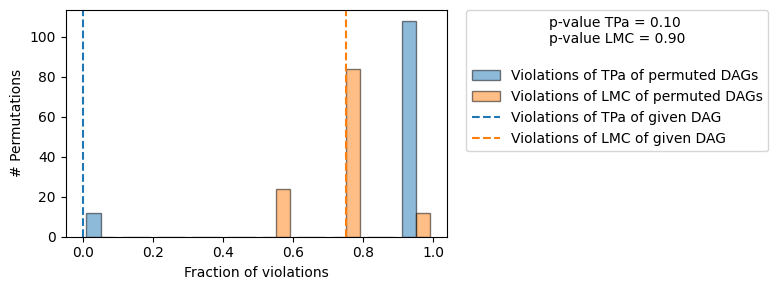

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is not informative because 12 / 120 of the permutations lie in the Markov               |
| equivalence class of the given DAG (p-value: 0.10).                                                   |
| The given DAG violates 6/8 LMCs and is better than 10.0% of the permuted DAGs (p-value: 0.90).        |
| Based on the provided significance level (0.05) and because the DAG is not informative,               |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
|                                             

In [15]:
result = falsify_graph(
    causal_graph=model._graph._graph,
    data=validation_set,
    plot_histogram=True,
    n_permutations=1000,  # Set a larger value to do maximum permutation
    suggestions=True,
)
# Summarize the result
print(result)

In [21]:
result.can_evaluate

True

## Causal Estimation DML

In [3]:
import pandas as pd
import os
import datetime
import numpy as np
import warnings
from dowhy import CausalModel

# Data Preprocessing
warnings.filterwarnings("ignore")
current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

folder_path = "Paper Experiment Results/New_filtered/Summary"
output_photo_name = f"SUM_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["model_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]


def string_encode(data):
    unique_strings = data.unique()
    string_map = {string: i for i, string in enumerate(unique_strings)}
    encoded_data = data.map(string_map)
    return encoded_data


encoded_dataset_name = string_encode(df["model_name"])
df["model_encoded"] = encoded_dataset_name

node_labels = [
    "Temperature",
    "model_encoded",
    "bert_F1",
    "rouge_l_fmeasure",
    "time_per_char",
]
causal_dataset_df = df[node_labels]
grouped = causal_dataset_df.groupby(["Temperature", "model_encoded"])
train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    train = group.sample(frac=0.6, random_state=42)
    validation = group.drop(train.index)
    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(validation_set)}")

Train set size: 8869
Validation set size: 5929


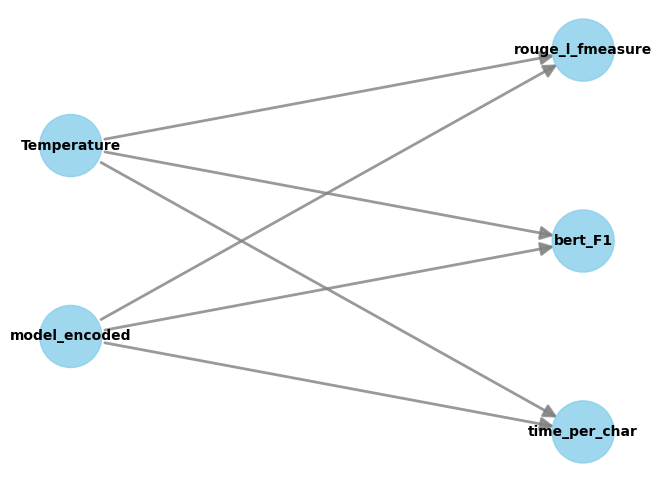

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                            
──────────────(E[rouge_l_fmeasure])
d[Temperature]                     
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→rouge_l_fmeasure then P(rouge_l_fmeasure|Temperature,,U) = P(rouge_l_fmeasure|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [5]:
model = CausalModel(
    data=train_set,
    treatment=["Temperature"],
    outcome=["rouge_l_fmeasure", "bert_F1", "time_per_char"],
    effect_modifiers=["model_encoded"],
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

# result = falsify_graph(
#     causal_graph=model._graph._graph,
#     data=validation_set,
#     plot_histogram=True,
#     n_permutations=1000,  # Set a larger value to do maximum permutation
#     suggestions=True,
# )
# # Summarize the result
# print(result)

In [29]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV

start = 0
end = 2
num_points = 10
step = (end - start) / num_points
points = np.arange(start, end, step)
results_df = pd.DataFrame(
    columns=[
        "weight_size",
        "control_value",
        "treatement_value",
        "estimation_interpretation",
        "estimation_params",
        "estimation_effect",
    ]
)

In [42]:
model_y = LinearRegression()
model_t = LinearRegression()

dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value=0.7,
    treatment_value=0.8,
    # confidence_intervals=False,
    target_units=lambda df: df["model_encoded"] == 0,
    # evaluate_effect_strength=True,
    method_params={
        "init_params": {
            "model_y": model_y,
            "model_t": model_t,
            "model_final": LassoCV(fit_intercept=False),
            "featurizer": PolynomialFeatures(degree=1, include_bias=False),
        },
        "fit_params": {},
    },
)

In [80]:
fitted_dml_model = dml_estimate.estimator.estimator
fitted_dml_model

In [58]:
fitted_model_y = fitted_dml_model.estimator.model_y

In [64]:
fitted_model_y.fit_intercept

True

In [77]:
est.intercept_

In [78]:
est.coef_

array([ 0.48825224,  0.00105952,  0.00244131,  0.02217944, -0.08471421])

In [22]:
dml_estimate.estimator.effect_interval

<bound method Econml.effect_interval of <dowhy.causal_estimators.econml.Econml object at 0x7fbaf0225130>>

In [21]:
dml_estimate.estimate_conditional_effects

<bound method CausalEstimate.estimate_conditional_effects of <dowhy.causal_estimator.CausalEstimate object at 0x7fbaefe9c790>>